In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import datetime as dt
from datetime import datetime
import bz2
import pickle
import _pickle as cPickle

%matplotlib inline

In [ ]:
tickers = pd.read_csv('russel2000.csv', header=None)

In [ ]:
tickers = tickers[0].to_list()

In [294]:
tickers = ['SPY', 'EZA', 'ASTGRP.CO']
stocks = download_tickers(tickers)

In [295]:
stocks.iloc[-200:-1, :]

Stock ticker         SPY                                                  \
Data type           Open        High         Low       Close   Adj Close   
Date                                                                       
2019-11-26    313.410004  314.279999  313.059998  314.079987  309.354919   
2019-11-27    314.609985  315.480011  314.369995  315.480011  310.733856   
2019-11-29    314.859985  315.130005  314.059998  314.309998  309.581451   
2019-12-02    314.589996  314.660004  311.170013  311.640015  306.951691   
2019-12-03    308.649994  309.640015  307.130005  309.549988  304.893066   
...                  ...         ...         ...         ...         ...   
2020-08-28    349.440002  350.720001  348.149994  350.579987  350.579987   
2020-08-31    350.350006  351.299988  349.059998  349.309998  349.309998   
2020-09-01    350.209991  352.709991  349.239990  352.600006  352.600006   
2020-09-02    354.670013  358.750000  353.429993  357.700012  357.700012   
2020-09-03    355.869995  356.380005  342.589996  345.390015  345.390015   

Stock ticker                     EZA                                   \
Data type          Volume       Open       High        Low      Close   
Date                                                                    
2019-11-26     37569000.0  50.130001  50.310001  49.849998  50.209999   
2019-11-27     44444600.0  50.060001  50.470001  49.840000  49.970001   
2019-11-29     36592700.0  49.669998  49.750000  49.380001  49.549999   
2019-12-02     75767800.0  48.830002  49.180000  48.660000  49.130001   
2019-12-03     73941700.0  48.730000  49.070000  48.549999  49.070000   
...                   ...        ...        ...        ...        ...   
2020-08-28     48588900.0  38.619999  38.950001  38.340000  38.799999   
2020-08-31     66099200.0  37.759998  37.759998  36.930000  37.169998   
2020-09-01     54999300.0  38.430000  38.470001  38.049999  38.360001   
2020-09-02     69540000.0  37.619999  37.660000  37.110001  37.580002   
2020-09-03    147485600.0  37.070000  37.200001  36.259998  36.650002   

Stock ticker                      ASTGRP.CO                              \
Data type     Adj Close    Volume      Open  High   Low Close Adj Close   
Date                                                                      
2019-11-26    44.772232  535200.0       NaN   NaN   NaN   NaN       NaN   
2019-11-27    44.558224  201700.0       NaN   NaN   NaN   NaN       NaN   
2019-11-29    44.183708  253900.0       NaN   NaN   NaN   NaN       NaN   
2019-12-02    43.809196  351200.0       NaN   NaN   NaN   NaN       NaN   
2019-12-03    43.755695  394200.0       NaN   NaN   NaN   NaN       NaN   
...                 ...       ...       ...   ...   ...   ...       ...   
2020-08-28    38.799999  284300.0      5.00  5.10  4.96  5.00      5.00   
2020-08-31    37.169998  753200.0      5.02  5.02  4.76  4.85      4.85   
2020-09-01    38.360001  340800.0      4.77  4.99  4.77  4.94      4.94   
2020-09-02    37.580002  538200.0      4.97  4.97  4.56  4.79      4.79   
2020-09-03    36.650002  509800.0      4.83  5.00  4.79  4.94      4.94   

Stock ticker           
Data type      Volume  
Date                   
2019-11-26        NaN  
2019-11-27        NaN  
2019-11-29        NaN  
2019-12-02        NaN  
2019-12-03        NaN  
...               ...  
2020-08-28    42626.0  
2020-08-31    91599.0  
2020-09-01    63544.0  
2020-09-02    52942.0  
2020-09-03    77814.0  

[199 rows x 18 columns]

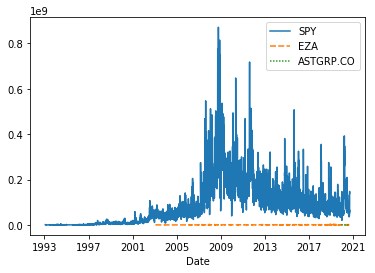

In [296]:
sns.lineplot(data=stocks.loc[:, stocks.columns.get_level_values(1).isin(['Volume'])])

In [ ]:
def download_tickers(tickers):
    # Fetch downloaded ticker from raw_data
    downloaded_tickers = [x[0:-5] if '.pbz2' in x else '' for x in os.listdir('raw_data/')]
    downloaded_tickers.remove('')
    # Check if tickers already are downloaded
    tickers_to_download = []
    for ticker in tickers:
        if ticker in downloaded_tickers:
            # If already downloaded, check if they need updates
            if update_ticker(ticker):
                tickers_to_download.append(ticker)
        else:
            tickers_to_download.append(ticker)

    not_downloaded = download_dump(tickers_to_download)
    tickers_to_load = [x for x in tickers if x not in not_downloaded]
    # Read tickers from json and return
    return load_stocks(tickers_to_load)

In [ ]:
def load_stocks(tickers):
    cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    index = pd.MultiIndex.from_product([tickers, cols], names=['Stock ticker', 'Data type'])
    if len(tickers) > 1:
        data = pd.concat([decompress_pickle('raw_data/' + x + '.pbz2') for x in tickers], axis=1, sort=True)
    else:
        data = decompress_pickle('raw_data/' + tickers[0] + '.pbz2')
    
    data.columns = index
    try:
        data.index = pd.to_datetime(data.index, unit='ms')
    except ValueError:
        data.index = pd.to_datetime(data.index)
    return data

In [ ]:
def update_ticker(ticker):
    last_bday = last_weekday()
    newest_date = decompress_pickle('raw_data/' + ticker + '.pbz2').index[-1]
    if newest_date == float:
        newest_date = dt.datetime.fromtimestamp(newest_date/1000).date()
    if newest_date != last_bday:
        return True 
    else:
        return False

In [ ]:
def download_dump(tickers):
    not_downloaded = []
    if tickers != []:
        data = yf.download(tickers, period='100y', group_by='tickers')
        if len(tickers) > 1:
            for ticker in tickers:
                    clean_data = clean_df(data[ticker])
                    if len(clean_data) > 1:
                        compressed_pickle(ticker, clean_data)
                    else:
                        not_downloaded.extend(tickers)
        else:
            clean_data = clean_df(data)
            if len(clean_data) > 1:
                compressed_pickle(tickers, clean_data)
            else:
                not_downloaded.extend(tickers)
                
    return not_downloaded 

In [ ]:
def last_weekday():
    todays_day = dt.date.today().day
    if todays_day in [5, 6]:
        return dt.date.today() - dt.timedelta(days=todays_day-4)
    else:
        return dt.date.today()


In [ ]:
def clean_df(df):
    df = df.dropna(axis = 0, how='all')
    return df

In [ ]:
def compressed_pickle(ticker, data):
    with bz2.BZ2File('raw_data/' + ticker + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

In [ ]:
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [283]:
test = decompress_pickle('raw_data/Y.pbz2')

In [284]:
test

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-01-02,0.000000,15.985246,15.910548,15.985246,2.992994,3300.0
1980-01-03,0.000000,15.835851,15.088877,15.835851,2.965021,12400.0
1980-01-04,0.000000,15.686457,15.537062,15.537062,2.909078,12200.0
1980-01-07,0.000000,15.537062,15.238272,15.537062,2.909078,84400.0
1980-01-08,0.000000,15.761153,15.387667,15.761153,2.951036,45700.0
...,...,...,...,...,...,...
2020-08-31,560.000000,560.000000,554.229980,554.559998,554.559998,51000.0
2020-09-01,554.000000,561.070007,551.000000,557.880005,557.880005,39200.0
2020-09-02,557.760010,571.890015,557.760010,567.210022,567.210022,55800.0


In [ ]:
sns.lineplot(data=test['Adj Close'])

In [ ]:
import os

def clean_raw_files():
    for filename in os.listdir('raw_data'):
        if filename.endswith(".pbz2"): 
            df = pd.DataFrame(decompress_pickle('raw_data/' + filename))
            non_zeroes = len(df) - df.iloc[:, 4].isna().sum()
            if non_zeroes < 2:
                os.remove('raw_data/' + filename)
            else:
                df = df.dropna(how='all', axis=0)
                ticker = filename.replace('.pbz2', '')
                compressed_pickle(ticker, df)
                  
remove_empties()